# Baby Steps of Machine Learning (Answer)

機械学習モデルを作成する基本的な手順を、ここで確認し行きます。今回は手書き文字の認識を行うモデルの作成を通じて、この手順の解説を行っていきます。

* [データロード](#Load-the-Data)
* [データの前処理](#Data-Preprocessing)
* [モデル構築](#Create-the-Model)
* [学習](#Train-the-Model)
* [評価](#Evaluate-the-Model)
* [保存](#Store-the-Model)

手順を進めていくにあたっては、[scikit-learn](http://scikit-learn.org/)という機械学習モデルを作るためのライブラリを使います。


In [2]:
# enable showing matplotlib image inline
%matplotlib inline

## Load the Data

機械学習は、データからルールを学習する技術です。

![machine_learning.PNG](./pictures/machine_learning.PNG)

そのため、まず第一にデータを用意する必要があります。幸い、scikit-learnには、最初から手書きの数字を認識するための学習データ(手書き数字の画像データと、その画像の数字が0～9の何れであるかという答えのセット)が搭載されているため、それを利用します。

In [3]:
from sklearn import datasets


def load_data():
    dataset = datasets.load_digits()
    return dataset

digits = load_data()
print(digits.data.shape)
print(digits.target.shape)

(1797, 64)
(1797,)


`digits.data.shape`で、データの行数、列数を表示しています。`1797`は行数、`64`は列数になりますです。これは、1797件の、64の特徴を持つデータであるということを意味しています。手書き文字の画像データは8×8のサイズであり、従ってその中のピクセルの数は64となるため特徴の数が64となっています(なお、RGB画像の場合はR、G、Bそれそれ64個あるため3倍になります)。  
これに対し、`digits.target.shape`はそのデータが実際にどの数字なのかの情報になります。つまり、教師データということです。  
実際に、データのうちの一つを表示してみます。

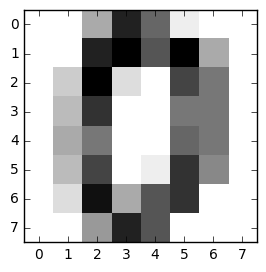

0


In [4]:
import numpy as np
import matplotlib.pyplot as plt    


def show_image(data):
    plt.figure(1, figsize=(3, 3))
    size = int(np.sqrt(len(data)))
    plt.imshow(np.reshape(data, (size, size)), cmap=plt.cm.gray_r, interpolation='nearest')
    plt.show()

show_image(digits.data[0])
print(digits.target[0])

`digits.data[0]`には"0"の画像データが収められており、`digits.target[0]`にはその答えである`0`が収められているのがわかるかと思います。

## Data Preprocessing

集めたデータがそのまま使える、ということは稀です。
精度の高いモデルを作るため、学習のスピードを上げるため、データをモデルにとって適切な形に加工する処理が欠かせません(生の食材を、調理するようなイメージです)。
多くの場合、この前処理が最終的な精度に大きなインパクトを与えます。今回は前処理の一つの手法である、正規化を実行してみます。

正規化とは、各特徴について平均を0、標準偏差を1にそろえることで学習の速度を上げるための処理です。
特徴Aは値が0.1~0.5、特徴Bは100~1000といった状況で、実は特徴Aの値のほうが判断には重要、となるとモデルにとってはその影響を見極めるのがとても困難になります。そのため、値の範囲をそろえるというのが正規化の役割です。  

In [5]:
def normalization(x):
    means = np.mean(x, axis=0)
    stds = np.std(x, axis=0)
    stds[stds < 1.0e-6] = np.max(x) - np.min(x)
    means[stds < 1.0e-6] = np.min(x)
    return means, stds

means, stds = normalization(digits.data)
print(means.shape)
print(stds.shape)

normalized_data = (digits.data - means) / stds  # normalization

(64,)
(64,)


## Create the Model

今回扱うのは画像の分類問題になります。分類に使えるモデルは沢山ありますが、今回は最もシンプルな線形分類機であるSGDClassifierを利用します。

In [6]:
def make_model():
    from sklearn.linear_model import SGDClassifier    
    clf = SGDClassifier(alpha=0.0001, fit_intercept=True)
    return clf
    
classifier = make_model()

本稿では各モデルの詳しい説明が目的ではないので、ここでは「分類に使える何かのモデル(=数式)を作った」というぐらいの感覚でかまいません。scikit-learnでは、上記のように様々なモデルを簡単に作ることができます。

## Train the Model

ここで、データとモデルがそろったため、学習させてみます。

In [7]:
from sklearn.model_selection import train_test_split

# use 30% of data to test the model
test_size = 0.3
train_d, test_d, train_t, test_t = train_test_split(normalized_data, digits.target, test_size=test_size, random_state=0)
print("dataset is splited to train/test = {0} -> {1}, {2}".format(
        len(normalized_data), len(train_d), len(test_d))
     )

dataset is splited to train/test = 1797 -> 1257, 540


In [8]:
# training the model
classifier.fit(train_d, train_t)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=None, shuffle=True,
       verbose=0, warm_start=False)

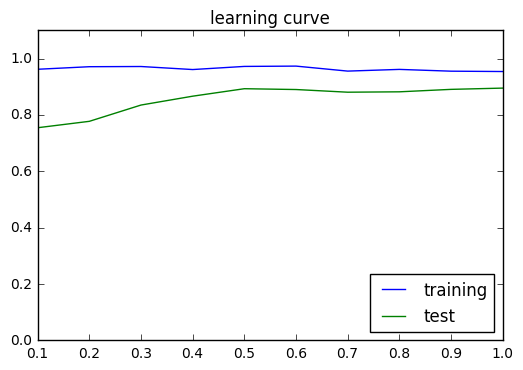

In [9]:
from sklearn.model_selection import learning_curve


def plot_learning_curve(model_func, dataset):
    sizes = [i / 10 for i in range(1, 11)]
    train_sizes, train_scores, valid_scores = learning_curve(model_func(), dataset.data, dataset.target, train_sizes=sizes, cv=5)
    
    take_means = lambda s: np.mean(s, axis=1)
    plt.plot(sizes, take_means(train_scores), label="training")
    plt.plot(sizes, take_means(valid_scores), label="test")
    plt.ylim(0, 1.1)
    plt.title("learning curve")
    plt.legend(loc="lower right")
    plt.show()

plot_learning_curve(make_model, digits)

## Evaluate the Model

In [10]:
from sklearn import metrics


predicted = classifier.predict(test_d)
score = metrics.accuracy_score(test_t, predicted)
print(score)

0.942592592593


In [11]:
from sklearn.metrics import classification_report


target_names = ["#{0}".format(i) for i in range(0, 10)]
print(classification_report(test_t, predicted, target_names=target_names))

             precision    recall  f1-score   support

         #0       1.00      0.98      0.99        45
         #1       0.84      0.92      0.88        52
         #2       0.96      0.89      0.92        53
         #3       0.94      0.93      0.93        54
         #4       0.92      1.00      0.96        48
         #5       0.96      0.96      0.96        57
         #6       0.98      0.98      0.98        60
         #7       0.94      0.92      0.93        53
         #8       0.95      0.89      0.92        61
         #9       0.93      0.96      0.95        57

avg / total       0.94      0.94      0.94       540



## Store the Model

In [13]:
from sklearn.externals import joblib

joblib.dump(classifier, "./machine.pkl") 

['./machine.pkl']